In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [11]:
model_names = ["dlpo_ls_sample", "dlpo_ls_sample_shuffle"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [12]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [13]:
all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
dlpo_ls_sample,7.817940,9.807853,0.797110,1.420321,-3.972846,-11.889022,0.488682
dlpo_ls_sample_shuffle,2.940817,11.919121,0.246731,0.411068,-5.939330,-22.189937,0.496671


## 2) Cummulative Returns of the Portfolios

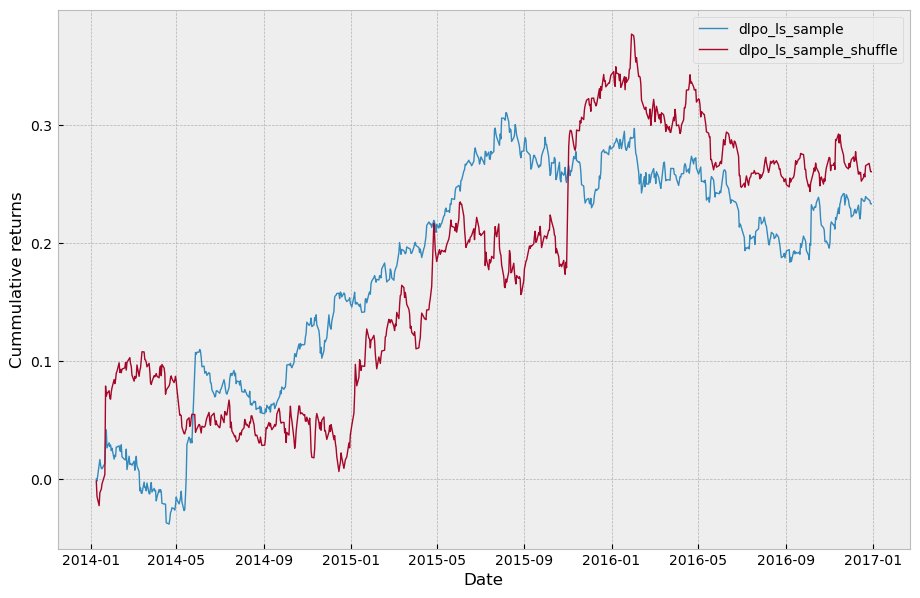

In [14]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2014-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [26]:
check_name = "dlpo_lo_sample"

all_summary_df.loc[all_summary_df["model"] == check_name, ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [27]:
all_summary_df.loc[all_summary_df["returns"] >= 1.11]

,date,ticker,returns,weights,pnl,model
34608,2016-10-07,AA,1.117032,0.045317,0.050620,dlpo_ls_sample
34608,2016-10-07,AA,1.117032,0.021923,0.024489,dlpo_ls_sample_shuffle


<Axes: title={'center': 'AA returns'}, xlabel='date'>

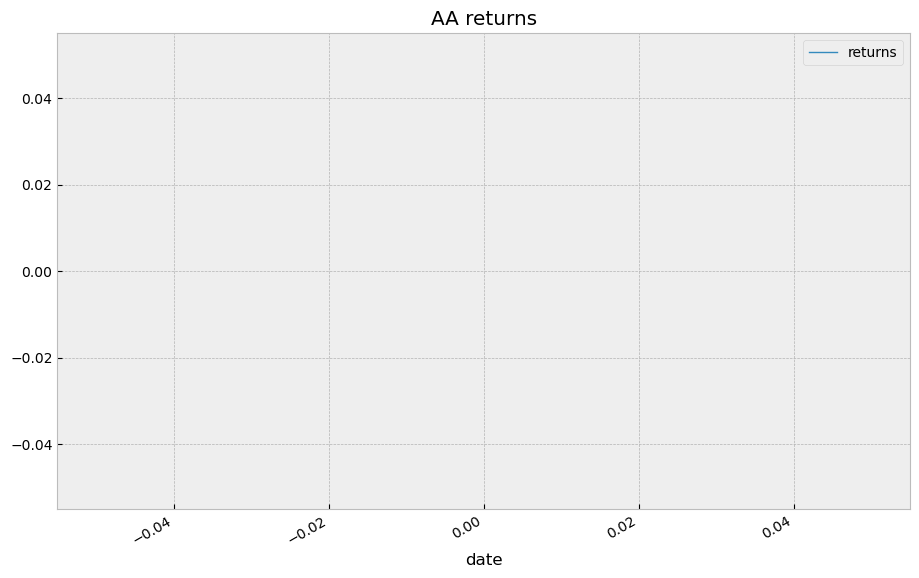

In [28]:
stock_name = "AA"

check_stock_df = all_summary_df.loc[(all_summary_df["model"] == check_name)&(all_summary_df["ticker"] == stock_name)][["date", "returns"]]
check_stock_df["date"] = pd.to_datetime(check_stock_df["date"])
check_stock_df.set_index("date", inplace=True)

check_stock_df.plot(figsize=(11, 7), title="{} returns".format(stock_name))